In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy as sp
import matplotlib as mpl
import seaborn as sns

# Setting up Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

# Setting up Seaborn
sns.set_style("whitegrid")
#sns.set_context("poster")

%matplotlib inline

In [4]:
train = pd.read_csv('training_data.csv')
test = pd.read_csv('test_data.csv')

In [5]:
training = train.drop('status_group', axis=1)

In [6]:
training = training.drop('Unnamed: 0', axis=1)

test = test.drop('Unnamed: 0', axis=1)

In [7]:
##Plot function for Confusion Matrix

#plt.rcParams['figure.figsize'] = (6.0, 6.0)
from sklearn.metrics import confusion_matrix
labels=['functional','functional needs repair','non functional']
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.YlOrRd):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha='right', fontsize=12)
    plt.yticks(tick_marks, labels , fontsize=12)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

## Because we are having maximum amount of Categorical data let us transform the features, and convert them into list

In [8]:
def transform_feature(df, column_name):
    unique_values = set(df[column_name].tolist())
    transformer_dict = {}
    for index, value in enumerate(unique_values):
        transformer_dict[value] = index
    df[column_name] = df[column_name].apply(lambda y: transformer_dict[y])
    return df

In [9]:
integer_columns = ['days_since_recorded', 'population','gps_height'] 
columns_to_transform = [col for col in training.columns if col not in integer_columns]
for column in columns_to_transform: 
    training = transform_feature(training, column)
    test = transform_feature(test, column)

## Now That we have Cleaned our dataset and Transformed our features, let us train our Model.

In [10]:
## Converting the Training dataframe into a matrix and predictor as y 
X = training.as_matrix()
y = train["status_group"].tolist()

> Splitting the Data Set with features into Train set  and Test set to train our model.

In [11]:
import sklearn.model_selection 
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, 
                                                                             y, 
                                                                             test_size = 0.3, 
                                                                             random_state = 0)

> As a part of EDA let us traing the data using different algorithms and findout which give us the better result.

The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability/robustness over a single estimator.

## Random Forest Classifier

In [12]:
import sklearn.ensemble

rfc = sklearn.ensemble.RandomForestClassifier(n_estimators=1000, 
                                              min_samples_split=5,
                                              criterion='gini', 
                                              max_features='auto',
                                              oob_score=True,
                                              random_state=1,
                                              n_jobs=-1)

In [13]:
rfc.fit(X_train, y_train)

print('Random Forest Classifier Train Accuracy Score :', rfc.score(X_train, y_train))
print('Random Forest Classifier Test Score :', rfc.score(X_test, y_test))

Random Forest Classifier Train Accuracy Score : 0.9521404521404522
Random Forest Classifier Test Score : 0.8035914702581369


In [14]:
print(rfc.feature_importances_)

[0.03707306 0.10783352 0.03306988 0.08187243 0.02508837 0.03494274
 0.10327543 0.05534092 0.01310725 0.0288586  0.04740058 0.0166014
 0.03785983 0.06374766 0.03748504 0.02062746 0.15469993 0.02621351
 0.00900909 0.03990183 0.02599146]


Text(0,0.5,'Importance')

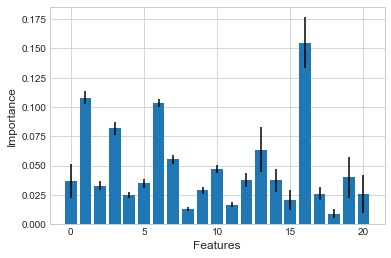

In [15]:
importance = rfc.feature_importances_
importance = pd.DataFrame(importance, index=training.columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_ 
                            for tree in rfc.estimators_], axis=0)

x = range(importance.shape[0])
y = importance.iloc[:, 0]
yerr = importance.iloc[:, 1]
lables = list(training.columns.values)



ax = plt.bar(x, y, yerr=yerr ,align="center")
plt.xlabel('Features', fontsize = 12)
plt.ylabel('Importance', fontsize = 12)

#plt.show()

In [16]:
test.head()

,amount_tsh,days_since_recorded,funder,gps_height,installer,basin,subvillage,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,payment_type,water_quality,quantity_group,source_type,source_class,waterpoint_type,waterpoint_type_group
0,0,302,2,1996,3,7,6318,321,2,10,0,2,6,1,3,7,2,2,0,3,3
1,0,302,6,1569,9,0,8023,300,2,8,1615,2,2,9,3,7,3,4,2,4,4
2,0,305,2,1567,3,7,6280,500,2,8,1484,0,6,1,3,7,3,2,0,3,3
3,0,315,2,267,3,1,7950,250,0,8,0,2,5,1,4,7,0,3,2,3,3
4,65,251,2,1260,3,1,6222,60,0,2,991,2,2,9,5,7,1,4,2,4,4


In [17]:
list(training.columns.values)

['amount_tsh',
 'days_since_recorded',
 'funder',
 'gps_height',
 'installer',
 'basin',
 'subvillage',
 'population',
 'public_meeting',
 'scheme_management',
 'scheme_name',
 'permit',
 'construction_year',
 'extraction_type',
 'payment_type',
 'water_quality',
 'quantity_group',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

In [18]:
from sklearn.metrics import classification_report

In [19]:
predicted = rfc.predict(X_test)

In [20]:
report = classification_report(y_test, predicted)
print(report)

                         precision    recall  f1-score   support

             functional       0.79      0.90      0.84      9612
functional needs repair       0.61      0.30      0.40      1333
         non functional       0.84      0.77      0.80      6875

            avg / total       0.80      0.80      0.79     17820



Confusion matrix
[[8652  183  777]
 [ 741  394  198]
 [1531   70 5274]]


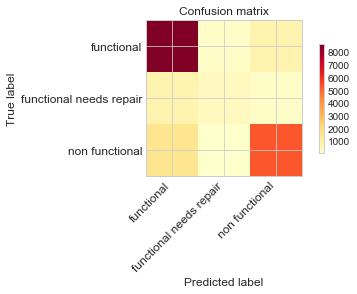

In [21]:
## Constructing the Confusion Matrix
cm = confusion_matrix(y_test, rfc.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

In [20]:
from sklearn.model_selection import cross_val_score  
all_accuracies = cross_val_score(estimator=rfc, X=X_train, y=y_train, cv=5)

In [21]:
print(all_accuracies)

[0.8 0.8 0.8 0.8 0.8]


In [22]:
print(all_accuracies.mean()) 

0.8010821435200363


In [23]:
print(all_accuracies.std())  

0.0029234468163992435


## Predictions

In [ ]:
predict = rfc.predict(test)

In [ ]:
submission = pd.read_csv('SubmissionFormat.csv')

In [ ]:
Final_merge = pd.concat([test, submission], axis=1)

In [ ]:
Final_merge.head()

In [ ]:
Final_merge['status_group'] = predict

In [ ]:
Final_merge[['id','status_group']].to_csv('Prediction.csv', index=False)

In [ ]:
sub = pd.read_csv('Prediction.csv')

In [ ]:
sub.head()

In [ ]:
sub.status_group.value_counts()